<a href="https://colab.research.google.com/github/ShaunCFernando/AI_Summer_Pitt/blob/main/AISummerSchool2025_PyTorch_MedicalImaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install medmnist livelossplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Data Setup, Visualization, and Loading

In [3]:
from medmnist import BloodMNIST
from pytorch_utils import image_grid

bloodmnist_train = BloodMNIST(split="train", download=True, size=224)
bloodmnist_valid = BloodMNIST(split="val", download=True, size=224)
bloodmnist_test = BloodMNIST(split="test", download=True, size=224)

100%|██████████| 1.54G/1.54G [07:11<00:00, 3.57MB/s]


In [4]:
# View table of classes
import pandas as pd
labels = bloodmnist_train.info["label"]
num_labels = len(labels)

pd.DataFrame.from_dict({
    "Class ID": labels.keys(),
    "Class Name": labels.values()
})

Class ID                                         Class Name
0        0                                           basophil
1        1                                         eosinophil
2        2                                       erythroblast
3        3  immature granulocytes(myelocytes, metamyelocyt...
4        4                                         lymphocyte
5        5                                           monocyte
6        6                                         neutrophil
7        7                                           platelet

basophil


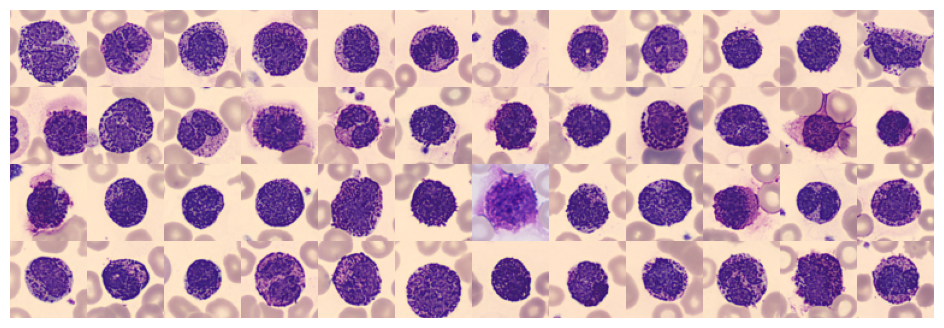

eosinophil


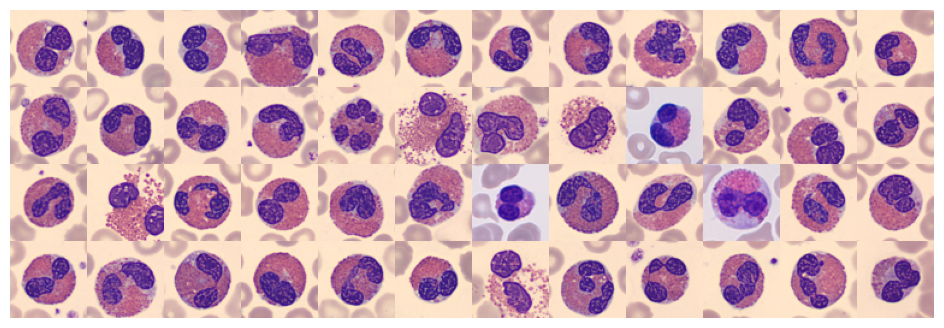

erythroblast


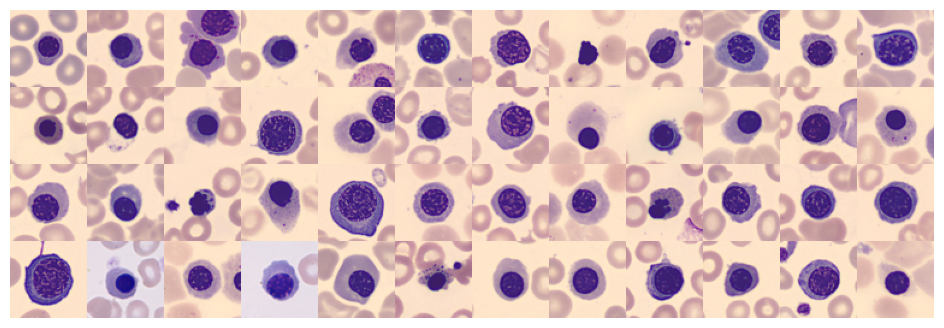

immature granulocytes(myelocytes, metamyelocytes and promyelocytes)


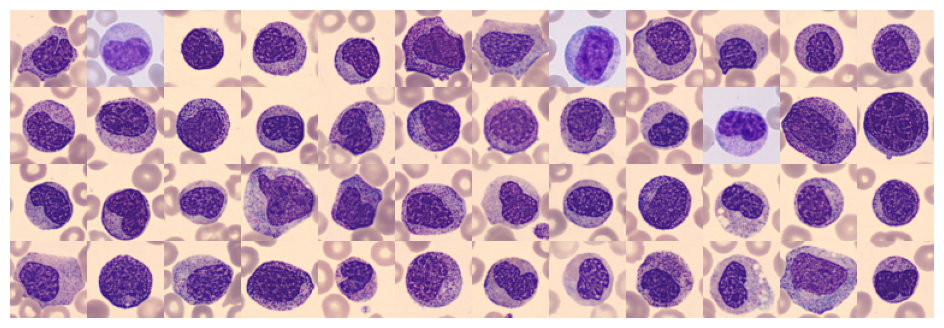

lymphocyte


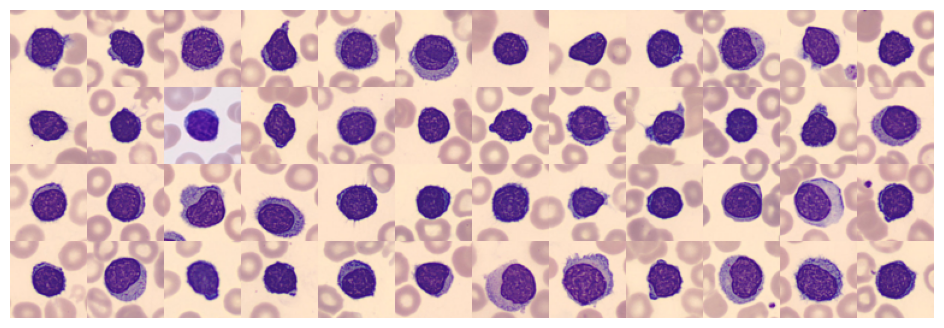

monocyte


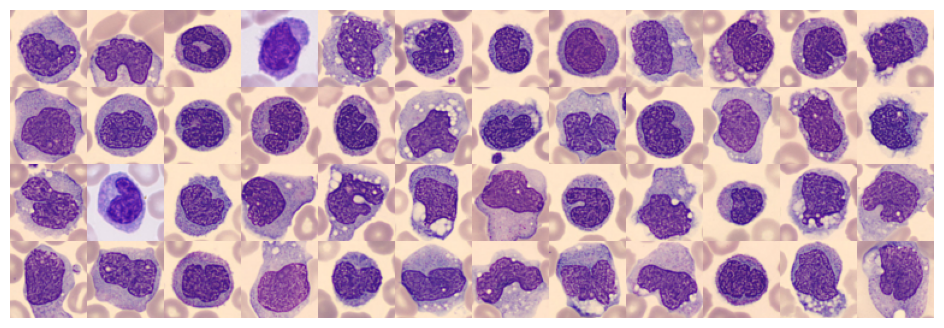

neutrophil


platelet


In [5]:
# Display examples from each class
for i in range(num_labels):
    print(labels[str(i)])
    image_grid(i, bloodmnist_train)


### Training a Neural Network

In [6]:
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader

transforms = T.Compose([T.ToTensor()])

# Load datasets
bloodmnist_train = BloodMNIST(split="train", download=True, size=224, transform=transforms)
bloodmnist_valid = BloodMNIST(split="val", download=True, size=224, transform=transforms)
bloodmnist_test = BloodMNIST(split="test", download=True, size=224, transform=transforms)

# Setup dataloader
train_loader = DataLoader(bloodmnist_train, batch_size=32, shuffle=True)
valid_loader = DataLoader(bloodmnist_valid, batch_size=32, shuffle=False)
test_loader = DataLoader(bloodmnist_test, batch_size=32, shuffle=False)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Create Vision Transformer (ViT) model
class BloodMNISTViT(nn.Module):
    def __init__(self, num_classes, freeze=True):
        super(BloodMNISTViT, self).__init__()
        # Load torchvision pretrained model
        self.vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

        # Set classification head to fit the new number of classes
        self.vit.heads.head = nn.Linear(self.vit.heads.head.in_features, num_classes)


        if freeze:
            # Freeze all layers except the final classification head
            for name, module in self.vit.named_children():
                if name != 'heads':
                    for param in module.parameters():
                        param.requires_grad = False


    def forward(self, x):
        # Feed input through the model
        return self.vit(x)

In [9]:
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

# Define training function
def train(model, train_loader, valid_loader, epochs=5, lr=0.001):
    # Determine device for training: GPU if Cuda is available, else CPU.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to device
    model.to(device)

    # Setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Plot the loss and accuracy throughout training
    acc_loss_plot = PlotLosses()

    # Keep track of best accuracy
    best_acc = 0.0

    # Training
    for epoch in range(epochs):
        logs = {}

        # Set model to train mode
        model.train()
        train_loss = 0.0
        train_correct = 0

        # Loop through dataloader batches
        for images, labels in train_loader:
            # Move images and labels to device
            images, labels = images.to(device), labels.squeeze().to(device)

            # Clear optimizer
            optimizer.zero_grad()

            # Get model prediction
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backpropagation
            loss.backward()

            # Optimize
            optimizer.step()

            # Calculate loss and accuracy for batch
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += torch.sum(preds == labels).item()

        # Log the epoch loss and accuracy
        logs["loss"] = train_loss / len(train_loader)
        logs["acc"] = train_correct / len(train_loader.dataset)

        # Validation
        valid_loss = 0.0
        valid_correct = 0

        # Don't accumulate the gradients for validation
        with torch.no_grad():
            # Loop through validation batches
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.squeeze().to(device)
                outputs = model(images)

                # Compute validation loss (not necessary)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)

                # Compute accuracy for batch
                _, preds = torch.max(outputs, 1)
                valid_correct += torch.sum(preds == labels).item()

        # Log the epoch validation loss and accuracy
        logs["val_loss"] = valid_loss / len(valid_loader)
        logs["val_acc"] = valid_correct / len(valid_loader.dataset)

         # Save the parameters for the best accuracy on the validation set so far.
        if logs['valid_acc'] > best_acc:
            best_acc = logs['valid_acc']
            torch.save(model.state_dict(), 'best_model_so_far.pth')

        # Update the plot with new logging information
        acc_loss_plot.update(logs)
        acc_loss_plot.send()


In [1]:
# Create model and train
model = BloodMNISTViT(num_labels)
train(model, train_loader, valid_loader, epochs=10)

NameError: name 'BloodMNISTViT' is not defined

## Model Evaluation

In [2]:
def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_predictions = []
    test_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.squeeze().to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            test_predictions.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    return test_predictions, test_labels



In [3]:
# Load best model and get test predictions and labels
best_model = BloodMNISTViT(num_labels)
best_model.load_state_dict(torch.load('best_model_so_far.pth'))
test_predictions, test_labels = evaluate(best_model, test_loader)

NameError: name 'BloodMNISTViT' is not defined

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Create classification report -- Precision, Recall, F1-Score, and Accuracy
print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       244
           1       1.00      1.00      1.00       624
           2       0.99      0.97      0.98       311
           3       0.94      0.94      0.94       579
           4       0.99      0.98      0.99       243
           5       0.94      0.97      0.95       284
           6       0.97      0.97      0.97       666
           7       1.00      1.00      1.00       470

    accuracy                           0.97      3421
   macro avg       0.97      0.97      0.97      3421
weighted avg       0.97      0.97      0.97      3421

[[237   0   0   6   0   1   0   0]
 [  2 622   0   0   0   0   0   0]
 [  1   0 301   4   1   2   1   1]
 [  4   0   1 543   0  12  19   0]
 [  0   0   2   1 239   1   0   0]
 [  0   0   0   8   1 275   0   0]
 [  0   1   0  14   0   3 648   0]
 [  0   0   1   0   0   0   0 469]]


In [ ]:
# Generate confusion matrix
print(confusion_matrix(test_labels, test_predictions))

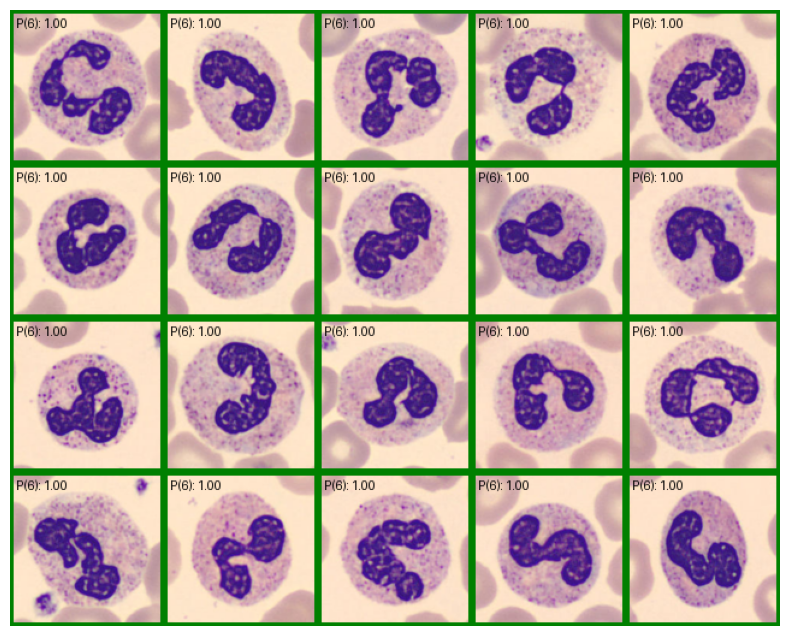

In [ ]:
from pytorch_utils import draw_class_prediction

# View class predictions
draw_class_prediction(model, bloodmnist_test, 6)